In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/PROJECT')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from myDataPreprocessing import myPreprocessor
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, initializers
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [4]:
DATA_DIR = "/content/gdrive/MyDrive/PROJECT/DATASET/UNSW-NB15/"
training_fname= "UNSW_NB15_training-set.csv"
testing_fname= "UNSW_NB15_testing-set.csv"

In [5]:
df1 = pd.read_csv(DATA_DIR + training_fname)
df2 =  pd.read_csv(DATA_DIR  + testing_fname)
df_ori = df1.append(df2, ignore_index=True)

In [6]:
df = df_ori.copy()

In [7]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [8]:
def Remove_dump_values(data, cols):
    for col in cols:
        data[col] = np.where(data[col] == '-', np.nan, data[col])
    return data

In [9]:
cols = df.columns
df = Remove_dump_values(df, cols)

In [10]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1.0,0.121478,tcp,NaN,FIN,6.0,4.0,258.0,172.0,74.087490,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Normal,0.0
1,2.0,0.649902,tcp,NaN,FIN,14.0,38.0,734.0,42014.0,78.473372,...,1.0,2.0,0.0,0.0,0.0,1.0,6.0,0.0,Normal,0.0
2,3.0,1.623129,tcp,NaN,FIN,8.0,16.0,364.0,13186.0,14.170161,...,1.0,3.0,0.0,0.0,0.0,2.0,6.0,0.0,Normal,0.0
3,4.0,1.681642,tcp,ftp,FIN,12.0,12.0,628.0,770.0,13.677108,...,1.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,Normal,0.0
4,5.0,0.449454,tcp,NaN,FIN,10.0,6.0,534.0,268.0,33.373826,...,1.0,40.0,0.0,0.0,0.0,2.0,39.0,0.0,Normal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,82328.0,0.000005,udp,NaN,INT,2.0,0.0,104.0,0.0,200000.005100,...,1.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,Normal,0.0
257669,82329.0,1.106101,tcp,NaN,FIN,20.0,8.0,18062.0,354.0,24.410067,...,1.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,Normal,0.0
257670,82330.0,0.000000,arp,NaN,INT,1.0,0.0,46.0,0.0,0.000000,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,Normal,0.0
257671,82331.0,0.000000,arp,NaN,INT,1.0,0.0,46.0,0.0,0.000000,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,Normal,0.0


In [11]:
df.isnull().sum()

id                        0
dur                       0
proto                     0
service              141321
state                     0
spkts                     0
dpkts                     0
sbytes                    0
dbytes                    0
rate                      0
sttl                      0
dttl                      0
sload                     0
dload                     0
sloss                     0
dloss                     0
sinpkt                    0
dinpkt                    0
sjit                      0
djit                      0
swin                      0
stcpb                     0
dtcpb                     0
dwin                      0
tcprtt                    0
synack                    0
ackdat                    0
smean                     0
dmean                     0
trans_depth               0
response_body_len         0
ct_srv_src                0
ct_state_ttl              0
ct_dst_ltm                0
ct_src_dport_ltm          0
ct_dst_sport_ltm    

In [12]:
# Drop id and attack cat, service
df.drop(['id','attack_cat','service'], axis=1, inplace = True)

In [13]:
x, y = myPreprocessor(df, 'mean', 'label')

Feature 'proto' has 133 unique categories
Feature 'state' has 11 unique categories


In [14]:
print(x.head())

        dur     proto  state     spkts     dpkts    sbytes    dbytes  \
0  0.002025  0.856061    0.4  0.000470  0.000363  0.000016  0.000012   
1  0.010832  0.856061    0.4  0.001221  0.003449  0.000049  0.002866   
2  0.027052  0.856061    0.4  0.000658  0.001452  0.000024  0.000900   
3  0.028027  0.856061    0.4  0.001033  0.001089  0.000042  0.000053   
4  0.007491  0.856061    0.4  0.000845  0.000545  0.000036  0.000018   

       rate      sttl      dttl  ...  ct_dst_ltm  ct_src_dport_ltm  \
0  0.000074  0.988235  1.000000  ...    0.000000          0.000000   
1  0.000078  0.243137  0.992126  ...    0.000000          0.000000   
2  0.000014  0.243137  0.992126  ...    0.017241          0.000000   
3  0.000014  0.243137  0.992126  ...    0.017241          0.000000   
4  0.000033  0.996078  0.992126  ...    0.017241          0.017241   

   ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0               0.0        0.000000          0.00        0.00   
1               

In [15]:
y.value_counts()

1.0    164673
0.0     93000
Name: label, dtype: int64

## Data Visualization

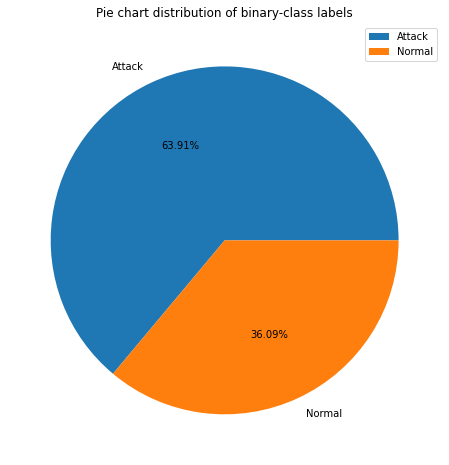

In [16]:
plt.figure(figsize=(8,8))
#plt.pie(y.value_counts(),labels=df.attack_cat.unique(),autopct='%0.2f%%')
plt.pie(y.value_counts(),labels=['Attack','Normal'],autopct='%0.2f%%')
plt.title('Pie chart distribution of binary-class labels')
plt.legend(loc='best')
plt.savefig('/content/gdrive/MyDrive/PROJECT/plots/Pie_chart_bin.png')
plt.show()

In [17]:
smote = SMOTE (sampling_strategy = 'minority')
x_sm, y_sm = smote.fit_resample(x, y)

In [18]:
y_sm.value_counts()

0.0    164673
1.0    164673
Name: label, dtype: int64

In [19]:
x_sm.shape, y_sm.shape

((329346, 41), (329346,))

In [20]:
x_array = np.array(x_sm)
y_array = np.array(y_sm)

In [21]:
x_3d =np.expand_dims(x_array, axis =2)

In [22]:
unique, counts = np.unique(y_array, return_counts=True)

dict(zip(unique, counts))

{0.0: 164673, 1.0: 164673}

## Model

In [23]:
cnn = models.Sequential([
    layers.Conv1D(32,3,activation='relu',padding='same', kernel_initializer='he_uniform', input_shape = (41, 1)),
    layers.Conv1D(32,3,activation='relu',padding='same',kernel_initializer='he_uniform'),
    layers.MaxPooling1D(pool_size=2,strides=2),
    
    layers.Dropout(0.002),
    layers.BatchNormalization(),
    
    layers.Conv1D(64,3,activation='relu',padding='same',kernel_initializer='he_uniform'),
    layers.Conv1D(64,3,activation='relu',padding='same',kernel_initializer='he_uniform'), 
    layers.MaxPooling1D(pool_size=2,strides=2), 
    layers.Dropout(0.002),
    layers.BatchNormalization(),   
    
    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dense(1,activation='sigmoid'),   #UNSW-NB15 is 2 and 10,CICIDS2017 is 15
])

cnn.summary()

# Compile the model
optimizer = 'Nadam'
nadam =optimizers.Nadam(learning_rate = 0.008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
cnn.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 41, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 41, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 batch_normalization (BatchN  (None, 20, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 64)            6

## Splitting K-Folds

In [ ]:
# Define the K-fold Cross Validator
n_folds = 6
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

## Model Fitting

In [ ]:
n_epochs = 15
batch_size = 256
verbosity = 1

# Define per-fold score containers
model_history = []
clr = []
cm_all=[]
acc_all=[]
loss_all=[]
recall_all=[]
precision_all=[]
f1_all=[]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=5)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skf.split(x_3d, y_array):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = cnn.fit(x_3d[train], y_array[train], 
                      batch_size=batch_size, 
                      epochs=n_epochs, 
                      verbose=verbosity, 
                      validation_split=0.2, 
                      callbacks = [reduce_lr])

    # Generate generalization metrics
    scores = cnn.evaluate(x_3d[test], y_array[test], verbose=0)
    print(f'\nScore for fold {fold_no}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100} %')

    y_preds = cnn.predict(x_3d[test])
    y_preds1 = np.round(y_preds)
    #y_preds_arg=np.argmax(y_preds1, axis=1)


    clr = classification_report(y_array[test], y_preds1, target_names=['Normal', 'Attack'])
    cm= confusion_matrix(y_array[test], y_preds1)
    accuracy = accuracy_score(y_array[test], y_preds1)
    recall = recall_score(y_array[test], y_preds1, average='weighted')
    precision = precision_score(y_array[test], y_preds1, average='weighted')
    f1 = f1_score(y_array[test], y_preds1, average='weighted')
    

    model_history.append(history)
    cm_all.append(cm)
    acc_all.append(accuracy * 100)
    loss_all.append(scores[0])
    recall_all.append(recall)
    precision_all.append(precision)
    f1_all.append(f1)

    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/15
858/858 [==============================] - 19s 16ms/step - loss: 0.1711 - accuracy: 0.9183 - val_loss: 0.1932 - val_accuracy: 0.9170 - lr: 0.0010
Epoch 2/15
858/858 [==============================] - 12s 15ms/step - loss: 0.1445 - accuracy: 0.9305 - val_loss: 0.1301 - val_accuracy: 0.9514 - lr: 0.0010
Epoch 3/15
858/858 [==============================] - 13s 15ms/step - loss: 0.1392 - accuracy: 0.9327 - val_loss: 0.2422 - val_accuracy: 0.8839 - lr: 0.0010
Epoch 4/15
858/858 [==============================] - 13s 15ms/step - loss: 0.1362 - accuracy: 0.9338 - val_loss: 0.1848 - val_accuracy: 0.9197 - lr: 0.0010
Epoch 5/15
858/858 [==============================] - 13s 15ms/step - loss: 0.1343 - accuracy: 0.9348 - val_loss: 0.1584 - val_accuracy: 0.9365 - lr: 0.0010
Epoch 6/15
858/858 [==============================] - 13s 15ms/step - loss: 0.1325 - accuracy: 0.9356 - val_loss: 0.16

## The FINAL Average Scores

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_all)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_all[i]} % - Loss: {loss_all[i]} - Recall: {recall_all[i]} - Precison: {precision_all[i]} - f1_score: {f1_all[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_all)} % (+- {np.std(acc_all)})')
print(f'> Loss: {np.mean(loss_all)}')
print(f'> Recall: {np.mean(recall_all)}')
print(f'> Precision: {np.mean(precision_all)}')
print(f'> F1-Score: {np.mean(f1_all)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 93.9862636862145 % - Loss: 0.12906230986118317 - Recall: 0.939862636862145 - Precison: 0.9398717662399794 - f1_score: 0.9398623274937028
------------------------------------------------------------------------
> Fold 2 - Accuracy: 94.17755187553514 % - Loss: 0.12711066007614136 - Recall: 0.9417755187553515 - Precison: 0.9417796603015965 - f1_score: 0.9417753840261569
------------------------------------------------------------------------
> Fold 3 - Accuracy: 94.26135432038039 % - Loss: 0.12542766332626343 - Recall: 0.9426135432038039 - Precison: 0.942627485047526 - f1_score: 0.9426130944350084
------------------------------------------------------------------------
> Fold 4 - Accuracy: 94.43988996374634 % - Loss: 0.12384168803691864 - Recall: 0.9443988996374634 - Precison: 0.9444143774005904 - f1_score: 0.

## Plotting Graph

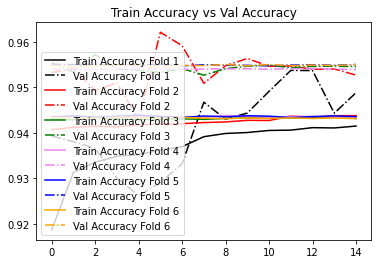

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='violet', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='violet', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='blue', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='blue', linestyle = "dashdot")
plt.plot(model_history[5].history['accuracy'], label='Train Accuracy Fold 6', color='orange', )
plt.plot(model_history[5].history['val_accuracy'], label='Val Accuracy Fold 6', color='orange', linestyle = "dashdot")
plt.legend(loc="lower left")
plt.savefig("/content/gdrive/MyDrive/PROJECT/plots/trainVsVal_acc3.png")
plt.show()

## Classification Report for all folds

In [ ]:
for i in range(n_folds):
  print(f"Fold {i+1}\n")
  print(clr)

Fold 1

              precision    recall  f1-score   support

      Normal       0.95      0.94      0.95     27445
      Attack       0.95      0.95      0.95     27446

    accuracy                           0.95     54891
   macro avg       0.95      0.95      0.95     54891
weighted avg       0.95      0.95      0.95     54891

Fold 2

              precision    recall  f1-score   support

      Normal       0.95      0.94      0.95     27445
      Attack       0.95      0.95      0.95     27446

    accuracy                           0.95     54891
   macro avg       0.95      0.95      0.95     54891
weighted avg       0.95      0.95      0.95     54891

Fold 3

              precision    recall  f1-score   support

      Normal       0.95      0.94      0.95     27445
      Attack       0.95      0.95      0.95     27446

    accuracy                           0.95     54891
   macro avg       0.95      0.95      0.95     54891
weighted avg       0.95      0.95      0.95     54

## Draw Confusion Matrix

Fold 1



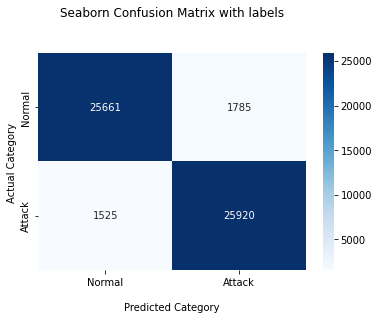

Fold 2



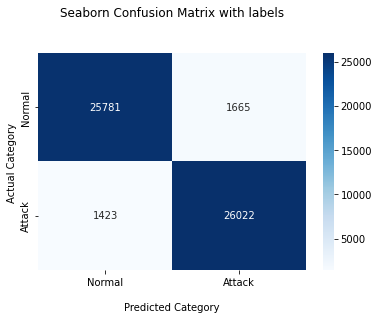

Fold 3



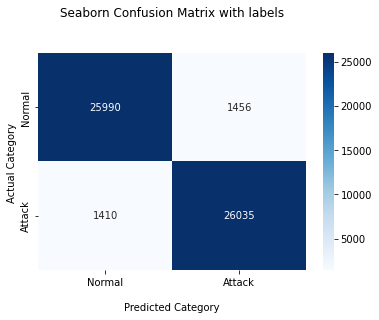

Fold 4



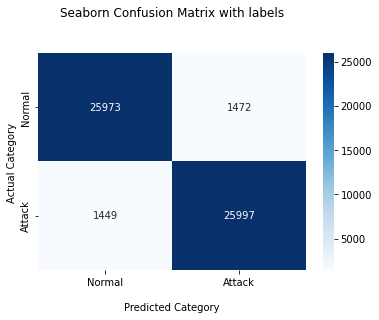

Fold 5



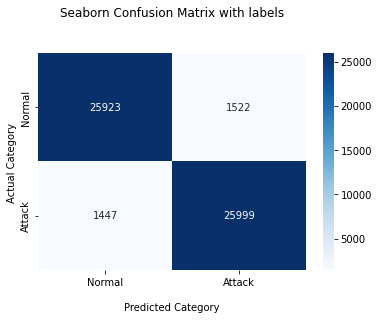

Fold 6



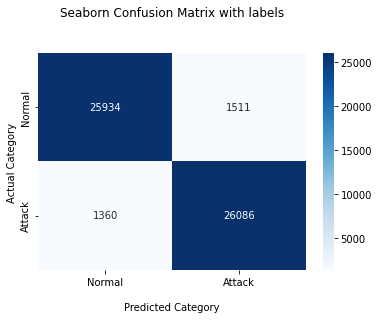

In [ ]:
import seaborn as sns
for i in range(n_folds):
  print(f"Fold {i+1}\n")
  ax = sns.heatmap(cm_all[i], annot=True, cmap='Blues', fmt='d')
  
  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Category')
  ax.set_ylabel('Actual Category ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['Normal','Attack'])
  ax.yaxis.set_ticklabels(['Normal','Attack'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

In [ ]:
cnn.save('/content/gdrive/MyDrive/PROJECT/model_bin/CNN1.1.h5')

Try 2 Sigmoid

In [ ]:
cnn = models.Sequential([
    layers.Conv1D(32,3,activation='sigmoid',padding='same', kernel_initializer='he_uniform', input_shape = (41, 1)),
    layers.Conv1D(32,3,activation='sigmoid',padding='same',kernel_initializer='he_uniform'),
    layers.MaxPooling1D(pool_size=2,strides=2),
    
    layers.Dropout(0.002),
    layers.BatchNormalization(),
    
    layers.Conv1D(64,3,activation='sigmoid',padding='same',kernel_initializer='he_uniform'),
    layers.Conv1D(64,3,activation='sigmoid',padding='same',kernel_initializer='he_uniform'), 
    layers.MaxPooling1D(pool_size=2,strides=2), 
    layers.Dropout(0.002),
    layers.BatchNormalization(),   
    
    layers.Flatten(),
    layers.Dense(32,activation='sigmoid'),
    layers.Dense(1,activation='sigmoid'),   #UNSW-NB15 is 2 and 10,CICIDS2017 is 15
])

cnn.summary()

# Compile the model
optimizer = 'Nadam'
nadam =optimizers.Nadam(learning_rate = 0.008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
cnn.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])

# Define the K-fold Cross Validator
n_folds = 6
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

n_epochs = 15
batch_size = 256
verbosity = 1

# Define per-fold score containers
model_history = []
clr = []
cm_all=[]
acc_all=[]
loss_all=[]
recall_all=[]
precision_all=[]
f1_all=[]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=5)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skf.split(x_3d, y_array):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = cnn.fit(x_3d[train], y_array[train], 
                      batch_size=batch_size, 
                      epochs=n_epochs, 
                      verbose=verbosity, 
                      validation_split=0.2, 
                      callbacks = [reduce_lr])

    # Generate generalization metrics
    scores = cnn.evaluate(x_3d[test], y_array[test], verbose=0)
    print(f'\nScore for fold {fold_no}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100} %')

    y_preds = cnn.predict(x_3d[test])
    y_preds1 = np.round(y_preds)
    #y_preds_arg=np.argmax(y_preds1, axis=1)


    clr = classification_report(y_array[test], y_preds1, target_names=['Normal', 'Attack'])
    cm= confusion_matrix(y_array[test], y_preds1)
    accuracy = accuracy_score(y_array[test], y_preds1)
    recall = recall_score(y_array[test], y_preds1, average='weighted')
    precision = precision_score(y_array[test], y_preds1, average='weighted')
    f1 = f1_score(y_array[test], y_preds1, average='weighted')
    

    model_history.append(history)
    cm_all.append(cm)
    acc_all.append(accuracy * 100)
    loss_all.append(scores[0])
    recall_all.append(recall)
    precision_all.append(precision)
    f1_all.append(f1)

    fold_no += 1


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 41, 32)            128       
                                                                 
 conv1d_5 (Conv1D)           (None, 41, 32)            3104      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 20, 32)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 20, 32)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 20, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_6 (Conv1D)           (None, 20, 64)           

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_all)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_all[i]} % - Loss: {loss_all[i]} - Recall: {recall_all[i]} - Precison: {precision_all[i]} - f1_score: {f1_all[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_all)} % (+- {np.std(acc_all)})')
print(f'> Loss: {np.mean(loss_all)}')
print(f'> Recall: {np.mean(recall_all)}')
print(f'> Precision: {np.mean(precision_all)}')
print(f'> F1-Score: {np.mean(f1_all)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 93.82958955019949 % - Loss: 0.13370729982852936 - Recall: 0.9382958955019949 - Precison: 0.9383768805290524 - f1_score: 0.9382930537675792
------------------------------------------------------------------------
> Fold 2 - Accuracy: 93.95711500974659 % - Loss: 0.13010884821414948 - Recall: 0.9395711500974658 - Precison: 0.9396515016574497 - f1_score: 0.9395683968996908
------------------------------------------------------------------------
> Fold 3 - Accuracy: 93.88606511085607 % - Loss: 0.13091786205768585 - Recall: 0.9388606511085607 - Precison: 0.9389248925075053 - f1_score: 0.9388584211315101
------------------------------------------------------------------------
> Fold 4 - Accuracy: 93.86966898034285 % - Loss: 0.1311192363500595 - Recall: 0.9386966898034286 - Precison: 0.938731641246494 - f1_score: 0

Try 3 tanh

In [ ]:
cnn = models.Sequential([
    layers.Conv1D(32,3,activation='tanh',padding='same', kernel_initializer='he_uniform', input_shape = (41, 1)),
    layers.Conv1D(32,3,activation='tanh',padding='same',kernel_initializer='he_uniform'),
    layers.MaxPooling1D(pool_size=2,strides=2),
    
    layers.Dropout(0.002),
    layers.BatchNormalization(),
    
    layers.Conv1D(64,3,activation='tanh',padding='same',kernel_initializer='he_uniform'),
    layers.Conv1D(64,3,activation='tanh',padding='same',kernel_initializer='he_uniform'), 
    layers.MaxPooling1D(pool_size=2,strides=2), 
    layers.Dropout(0.002),
    layers.BatchNormalization(),   
    
    layers.Flatten(),
    layers.Dense(32,activation='tanh'),
    layers.Dense(1,activation='sigmoid'),   #UNSW-NB15 is 2 and 10,CICIDS2017 is 15
])

cnn.summary()

# Compile the model
optimizer = 'Nadam'
nadam =optimizers.Nadam(learning_rate = 0.008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
cnn.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])

# Define the K-fold Cross Validator
n_folds = 6
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

n_epochs = 15
batch_size = 256
verbosity = 1

# Define per-fold score containers
model_history = []
clr = []
cm_all=[]
acc_all=[]
loss_all=[]
recall_all=[]
precision_all=[]
f1_all=[]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=5)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skf.split(x_3d, y_array):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = cnn.fit(x_3d[train], y_array[train], 
                      batch_size=batch_size, 
                      epochs=n_epochs, 
                      verbose=verbosity, 
                      validation_split=0.2, 
                      callbacks = [reduce_lr])

    # Generate generalization metrics
    scores = cnn.evaluate(x_3d[test], y_array[test], verbose=0)
    print(f'\nScore for fold {fold_no}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100} %')

    y_preds = cnn.predict(x_3d[test])
    y_preds1 = np.round(y_preds)
    #y_preds_arg=np.argmax(y_preds1, axis=1)


    clr = classification_report(y_array[test], y_preds1, target_names=['Normal', 'Attack'])
    cm= confusion_matrix(y_array[test], y_preds1)
    accuracy = accuracy_score(y_array[test], y_preds1)
    recall = recall_score(y_array[test], y_preds1, average='weighted')
    precision = precision_score(y_array[test], y_preds1, average='weighted')
    f1 = f1_score(y_array[test], y_preds1, average='weighted')
    

    model_history.append(history)
    cm_all.append(cm)
    acc_all.append(accuracy * 100)
    loss_all.append(scores[0])
    recall_all.append(recall)
    precision_all.append(precision)
    f1_all.append(f1)

    fold_no += 1

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 41, 32)            128       
                                                                 
 conv1d_9 (Conv1D)           (None, 41, 32)            3104      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 20, 32)           0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 20, 32)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 20, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_10 (Conv1D)          (None, 20, 64)           

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_all)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_all[i]} % - Loss: {loss_all[i]} - Recall: {recall_all[i]} - Precison: {precision_all[i]} - f1_score: {f1_all[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_all)} % (+- {np.std(acc_all)})')
print(f'> Loss: {np.mean(loss_all)}')
print(f'> Recall: {np.mean(recall_all)}')
print(f'> Precision: {np.mean(precision_all)}')
print(f'> F1-Score: {np.mean(f1_all)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 94.19759159060685 % - Loss: 0.12630122900009155 - Recall: 0.9419759159060684 - Precison: 0.9420348983161354 - f1_score: 0.9419739867527401
------------------------------------------------------------------------
> Fold 2 - Accuracy: 94.14111602995027 % - Loss: 0.12433420121669769 - Recall: 0.9414111602995027 - Precison: 0.9414558150181733 - f1_score: 0.9414096843711072
------------------------------------------------------------------------
> Fold 3 - Accuracy: 94.13747244539178 % - Loss: 0.125972718000412 - Recall: 0.9413747244539178 - Precison: 0.9414347469572064 - f1_score: 0.941372738185484
------------------------------------------------------------------------
> Fold 4 - Accuracy: 94.37430544169354 % - Loss: 0.12236393243074417 - Recall: 0.9437430544169354 - Precison: 0.9437885767538732 - f1_score: 0.

try 4 LeakyReLU

In [ ]:
cnn = models.Sequential([
    layers.Conv1D(32,3,activation='LeakyReLU',padding='same', kernel_initializer='he_uniform', input_shape = (41, 1)),
    layers.Conv1D(32,3,activation='LeakyReLU',padding='same',kernel_initializer='he_uniform'),
    layers.MaxPooling1D(pool_size=2,strides=2),
    
    layers.Dropout(0.002),
    layers.BatchNormalization(),
    
    layers.Conv1D(64,3,activation='LeakyReLU',padding='same',kernel_initializer='he_uniform'),
    layers.Conv1D(64,3,activation='LeakyReLU',padding='same',kernel_initializer='he_uniform'), 
    layers.MaxPooling1D(pool_size=2,strides=2), 
    layers.Dropout(0.002),
    layers.BatchNormalization(),   
    
    layers.Flatten(),
    layers.Dense(32,activation='LeakyReLU'),
    layers.Dense(1,activation='sigmoid'),   #UNSW-NB15 is 2 and 10,CICIDS2017 is 15
])

cnn.summary()

# Compile the model
optimizer = 'Nadam'
nadam =optimizers.Nadam(learning_rate = 0.008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
cnn.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])

# Define the K-fold Cross Validator
n_folds = 6
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

n_epochs = 15
batch_size = 256
verbosity = 1

# Define per-fold score containers
model_history = []
clr = []
cm_all=[]
acc_all=[]
loss_all=[]
recall_all=[]
precision_all=[]
f1_all=[]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=5)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skf.split(x_3d, y_array):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = cnn.fit(x_3d[train], y_array[train], 
                      batch_size=batch_size, 
                      epochs=n_epochs, 
                      verbose=verbosity, 
                      validation_split=0.2, 
                      callbacks = [reduce_lr])

    # Generate generalization metrics
    scores = cnn.evaluate(x_3d[test], y_array[test], verbose=0)
    print(f'\nScore for fold {fold_no}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100} %')

    y_preds = cnn.predict(x_3d[test])
    y_preds1 = np.round(y_preds)
    #y_preds_arg=np.argmax(y_preds1, axis=1)


    clr = classification_report(y_array[test], y_preds1, target_names=['Normal', 'Attack'])
    cm= confusion_matrix(y_array[test], y_preds1)
    accuracy = accuracy_score(y_array[test], y_preds1)
    recall = recall_score(y_array[test], y_preds1, average='weighted')
    precision = precision_score(y_array[test], y_preds1, average='weighted')
    f1 = f1_score(y_array[test], y_preds1, average='weighted')
    

    model_history.append(history)
    cm_all.append(cm)
    acc_all.append(accuracy * 100)
    loss_all.append(scores[0])
    recall_all.append(recall)
    precision_all.append(precision)
    f1_all.append(f1)

    fold_no += 1

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 41, 32)            128       
                                                                 
 conv1d_13 (Conv1D)          (None, 41, 32)            3104      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 20, 32)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 20, 32)            0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_14 (Conv1D)          (None, 20, 64)           

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_all)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_all[i]} % - Loss: {loss_all[i]} - Recall: {recall_all[i]} - Precison: {precision_all[i]} - f1_score: {f1_all[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_all)} % (+- {np.std(acc_all)})')
print(f'> Loss: {np.mean(loss_all)}')
print(f'> Recall: {np.mean(recall_all)}')
print(f'> Precision: {np.mean(precision_all)}')
print(f'> F1-Score: {np.mean(f1_all)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 93.97351114025979 % - Loss: 0.12952874600887299 - Recall: 0.9397351114025979 - Precison: 0.9397355070779669 - f1_score: 0.9397350984016349
------------------------------------------------------------------------
> Fold 2 - Accuracy: 93.68384616785994 % - Loss: 0.13387538492679596 - Recall: 0.9368384616785994 - Precison: 0.9368974976676683 - f1_score: 0.9368363350933729
------------------------------------------------------------------------
> Fold 3 - Accuracy: 93.78586653549762 % - Loss: 0.13226506114006042 - Recall: 0.9378586653549762 - Precison: 0.9378902347972357 - f1_score: 0.9378575504702771
------------------------------------------------------------------------
> Fold 4 - Accuracy: 94.10285839208613 % - Loss: 0.12854908406734467 - Recall: 0.9410285839208613 - Precison: 0.9410508409286376 - f1_score:

try 5 softmax

In [ ]:
cnn = models.Sequential([
    layers.Conv1D(32,3,activation='softmax',padding='same', kernel_initializer='he_uniform', input_shape = (41, 1)),
    layers.Conv1D(32,3,activation='softmax',padding='same',kernel_initializer='he_uniform'),
    layers.MaxPooling1D(pool_size=2,strides=2),
    
    layers.Dropout(0.002),
    layers.BatchNormalization(),
    
    layers.Conv1D(64,3,activation='softmax',padding='same',kernel_initializer='he_uniform'),
    layers.Conv1D(64,3,activation='softmax',padding='same',kernel_initializer='he_uniform'), 
    layers.MaxPooling1D(pool_size=2,strides=2), 
    layers.Dropout(0.002),
    layers.BatchNormalization(),   
    
    layers.Flatten(),
    layers.Dense(32,activation='softmax'),
    layers.Dense(1,activation='sigmoid'),   #UNSW-NB15 is 2 and 10,CICIDS2017 is 15
])

cnn.summary()

# Compile the model
optimizer = 'Nadam'
nadam =optimizers.Nadam(learning_rate = 0.008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
cnn.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])

# Define the K-fold Cross Validator
n_folds = 6
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

n_epochs = 15
batch_size = 256
verbosity = 1

# Define per-fold score containers
model_history = []
clr = []
cm_all=[]
acc_all=[]
loss_all=[]
recall_all=[]
precision_all=[]
f1_all=[]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=5)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skf.split(x_3d, y_array):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = cnn.fit(x_3d[train], y_array[train], 
                      batch_size=batch_size, 
                      epochs=n_epochs, 
                      verbose=verbosity, 
                      validation_split=0.2, 
                      callbacks = [reduce_lr])

    # Generate generalization metrics
    scores = cnn.evaluate(x_3d[test], y_array[test], verbose=0)
    print(f'\nScore for fold {fold_no}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100} %')

    y_preds = cnn.predict(x_3d[test])
    y_preds1 = np.round(y_preds)
    #y_preds_arg=np.argmax(y_preds1, axis=1)


    clr = classification_report(y_array[test], y_preds1, target_names=['Normal', 'Attack'])
    cm= confusion_matrix(y_array[test], y_preds1)
    accuracy = accuracy_score(y_array[test], y_preds1)
    recall = recall_score(y_array[test], y_preds1, average='weighted')
    precision = precision_score(y_array[test], y_preds1, average='weighted')
    f1 = f1_score(y_array[test], y_preds1, average='weighted')
    

    model_history.append(history)
    cm_all.append(cm)
    acc_all.append(accuracy * 100)
    loss_all.append(scores[0])
    recall_all.append(recall)
    precision_all.append(precision)
    f1_all.append(f1)

    fold_no += 1

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 41, 32)            128       
                                                                 
 conv1d_5 (Conv1D)           (None, 41, 32)            3104      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 20, 32)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 20, 32)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 20, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_6 (Conv1D)           (None, 20, 64)           

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_all)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_all[i]} % - Loss: {loss_all[i]} - Recall: {recall_all[i]} - Precison: {precision_all[i]} - f1_score: {f1_all[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_all)} % (+- {np.std(acc_all)})')
print(f'> Loss: {np.mean(loss_all)}')
print(f'> Recall: {np.mean(recall_all)}')
print(f'> Precision: {np.mean(precision_all)}')
print(f'> F1-Score: {np.mean(f1_all)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 93.20653659069794 % - Loss: 0.146736279129982 - Recall: 0.9320653659069793 - Precison: 0.9320693211978884 - f1_score: 0.9320652124516876
------------------------------------------------------------------------
> Fold 2 - Accuracy: 93.2958044123809 % - Loss: 0.13792912662029266 - Recall: 0.932958044123809 - Precison: 0.9334995758580394 - f1_score: 0.9329371234694778
------------------------------------------------------------------------
> Fold 3 - Accuracy: 93.71117305204861 % - Loss: 0.13181878626346588 - Recall: 0.937111730520486 - Precison: 0.937386611727506 - f1_score: 0.9371018636240801
------------------------------------------------------------------------
> Fold 4 - Accuracy: 93.87331256490134 % - Loss: 0.12734442949295044 - Recall: 0.9387331256490135 - Precison: 0.9388433496813006 - f1_score: 0.938